# Graph Theoretical Analysis

In [1]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import SigProc
import analysis_utils as au
from networkx.algorithms.approximation import clique
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
TRACE_RAW_DRD87 = "/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/Raw_EPM_drd87.csv"
data = pd.read_csv(TRACE_RAW_DRD87, header=None)
z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

# Rename all the columns from "neuron_x" --> "x". This makes the graphs neater by making sure the neuron names fit into the nodes
cell_transients_dataframe.columns = [i for i in range(1, len(cell_transients_dataframe.columns)+1)]

In [3]:
def create_graph(dataframe):
    G = nx.Graph()
    G.add_nodes_from(dataframe.columns)
    corr_pairs = au.find_correlated_pairs(dataframe, correlation_coeff=0.3)

    for key in corr_pairs:
        G.add_edge(key[0], key[1], weight=round(corr_pairs[key], 3))
        
    return G

In [4]:
def create_random_graph(dataframe):
    G = nx.Graph()
    G.add_nodes_from(dataframe.columns)
    corr_pairs = au.find_correlated_pairs(dataframe, correlation_coeff=0.3)

    # Connect a len(correlated_pairs_dict) amount of random edges between all the nodes in the random graph
    for i in range(len(corr_pairs)):
        G.add_edge(np.random.randint(1, len(dataframe.columns)+1), np.random.randint(1, len(dataframe.columns)+1))
        
    return G

In [5]:
def plot_graph(G):

    # positions for all nodes
    pos = nx.spring_layout(G, weight='weight') 

    plt.figure(figsize=(35, 35))

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue');

    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

    # edges
    nx.draw_networkx_edges(G, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=15, edge_labels=labels)

    plt.axis('off');
    plt.show();

In [6]:
def plot_random_graph(random_graph):
    
    # positions for all nodes
    pos = nx.spring_layout(random_graph, weight='weight') 

    plt.figure(figsize=(15, 15))

    # nodes
    nx.draw_networkx_nodes(random_graph, pos, node_size=700, node_color='lightblue');

    # edges
    nx.draw_networkx_edges(random_graph, pos, width=1.0); 

    labels = nx.get_edge_attributes(random_graph, 'weight')
    nx.draw_networkx_edge_labels(random_graph, pos, edge_labels=labels)

    # labels
    nx.draw_networkx_labels(random_graph, pos, font_size=15, edge_labels=labels)

    plt.axis('off');
    plt.show();

In [7]:
def compute_network_measures(graph):
    """
    
    args:
    
    returns:
    """
    network_measures_dict = dict()
    network_measures_dict["assortativity"] = nx.degree_assortativity_coefficient(graph) 
    network_measures_dict["mean betweenness centrality"] = compute_mean_betweenness_centrality(graph)
    #network_measures_dict["mean clique size"] = 
    network_measures_dict["max clique size"] = len(clique.max_clique(graph))
    network_measures_dict["clustering coefficient"] = nx.clustering(graph)
    #network_measures_dict["mean path length"] = 
    
    return network_measures_dict

In [8]:
def compute_mean_betweenness_centrality(graph):
    graph_centrality = nx.betweenness_centrality(graph)
    return np.mean(list(graph_centrality.values()))

## Now, we plot an undirected graph of the network of cells that were imaged for a given mouse
- Edges are added between pairs of neurons that had a correlation coefficient $\ge 3.0$
    - Each edge is weighted by the correlation coefficient corresponding to the two neurons it connects
    - The correlation coefficient between each corresponding pair of neurons is drawn on the edge between them
    - The color of each edge is determined by the correlation between the pair of neurons: 
        - yellow - correlated
        - green - strongly correlated 
        - blue - very strongly correlated
- Isolate nodes are also plotted
- No clustering algorithm was applied to this network of nodes... the graph drawing algorithm that was utilized keeps corresponding nodes clustered together by accounting for the weights of the edges
- Note that the clusters of nodes strongly correspond to the clusters created by the Seaborn library's cluster map data visualization

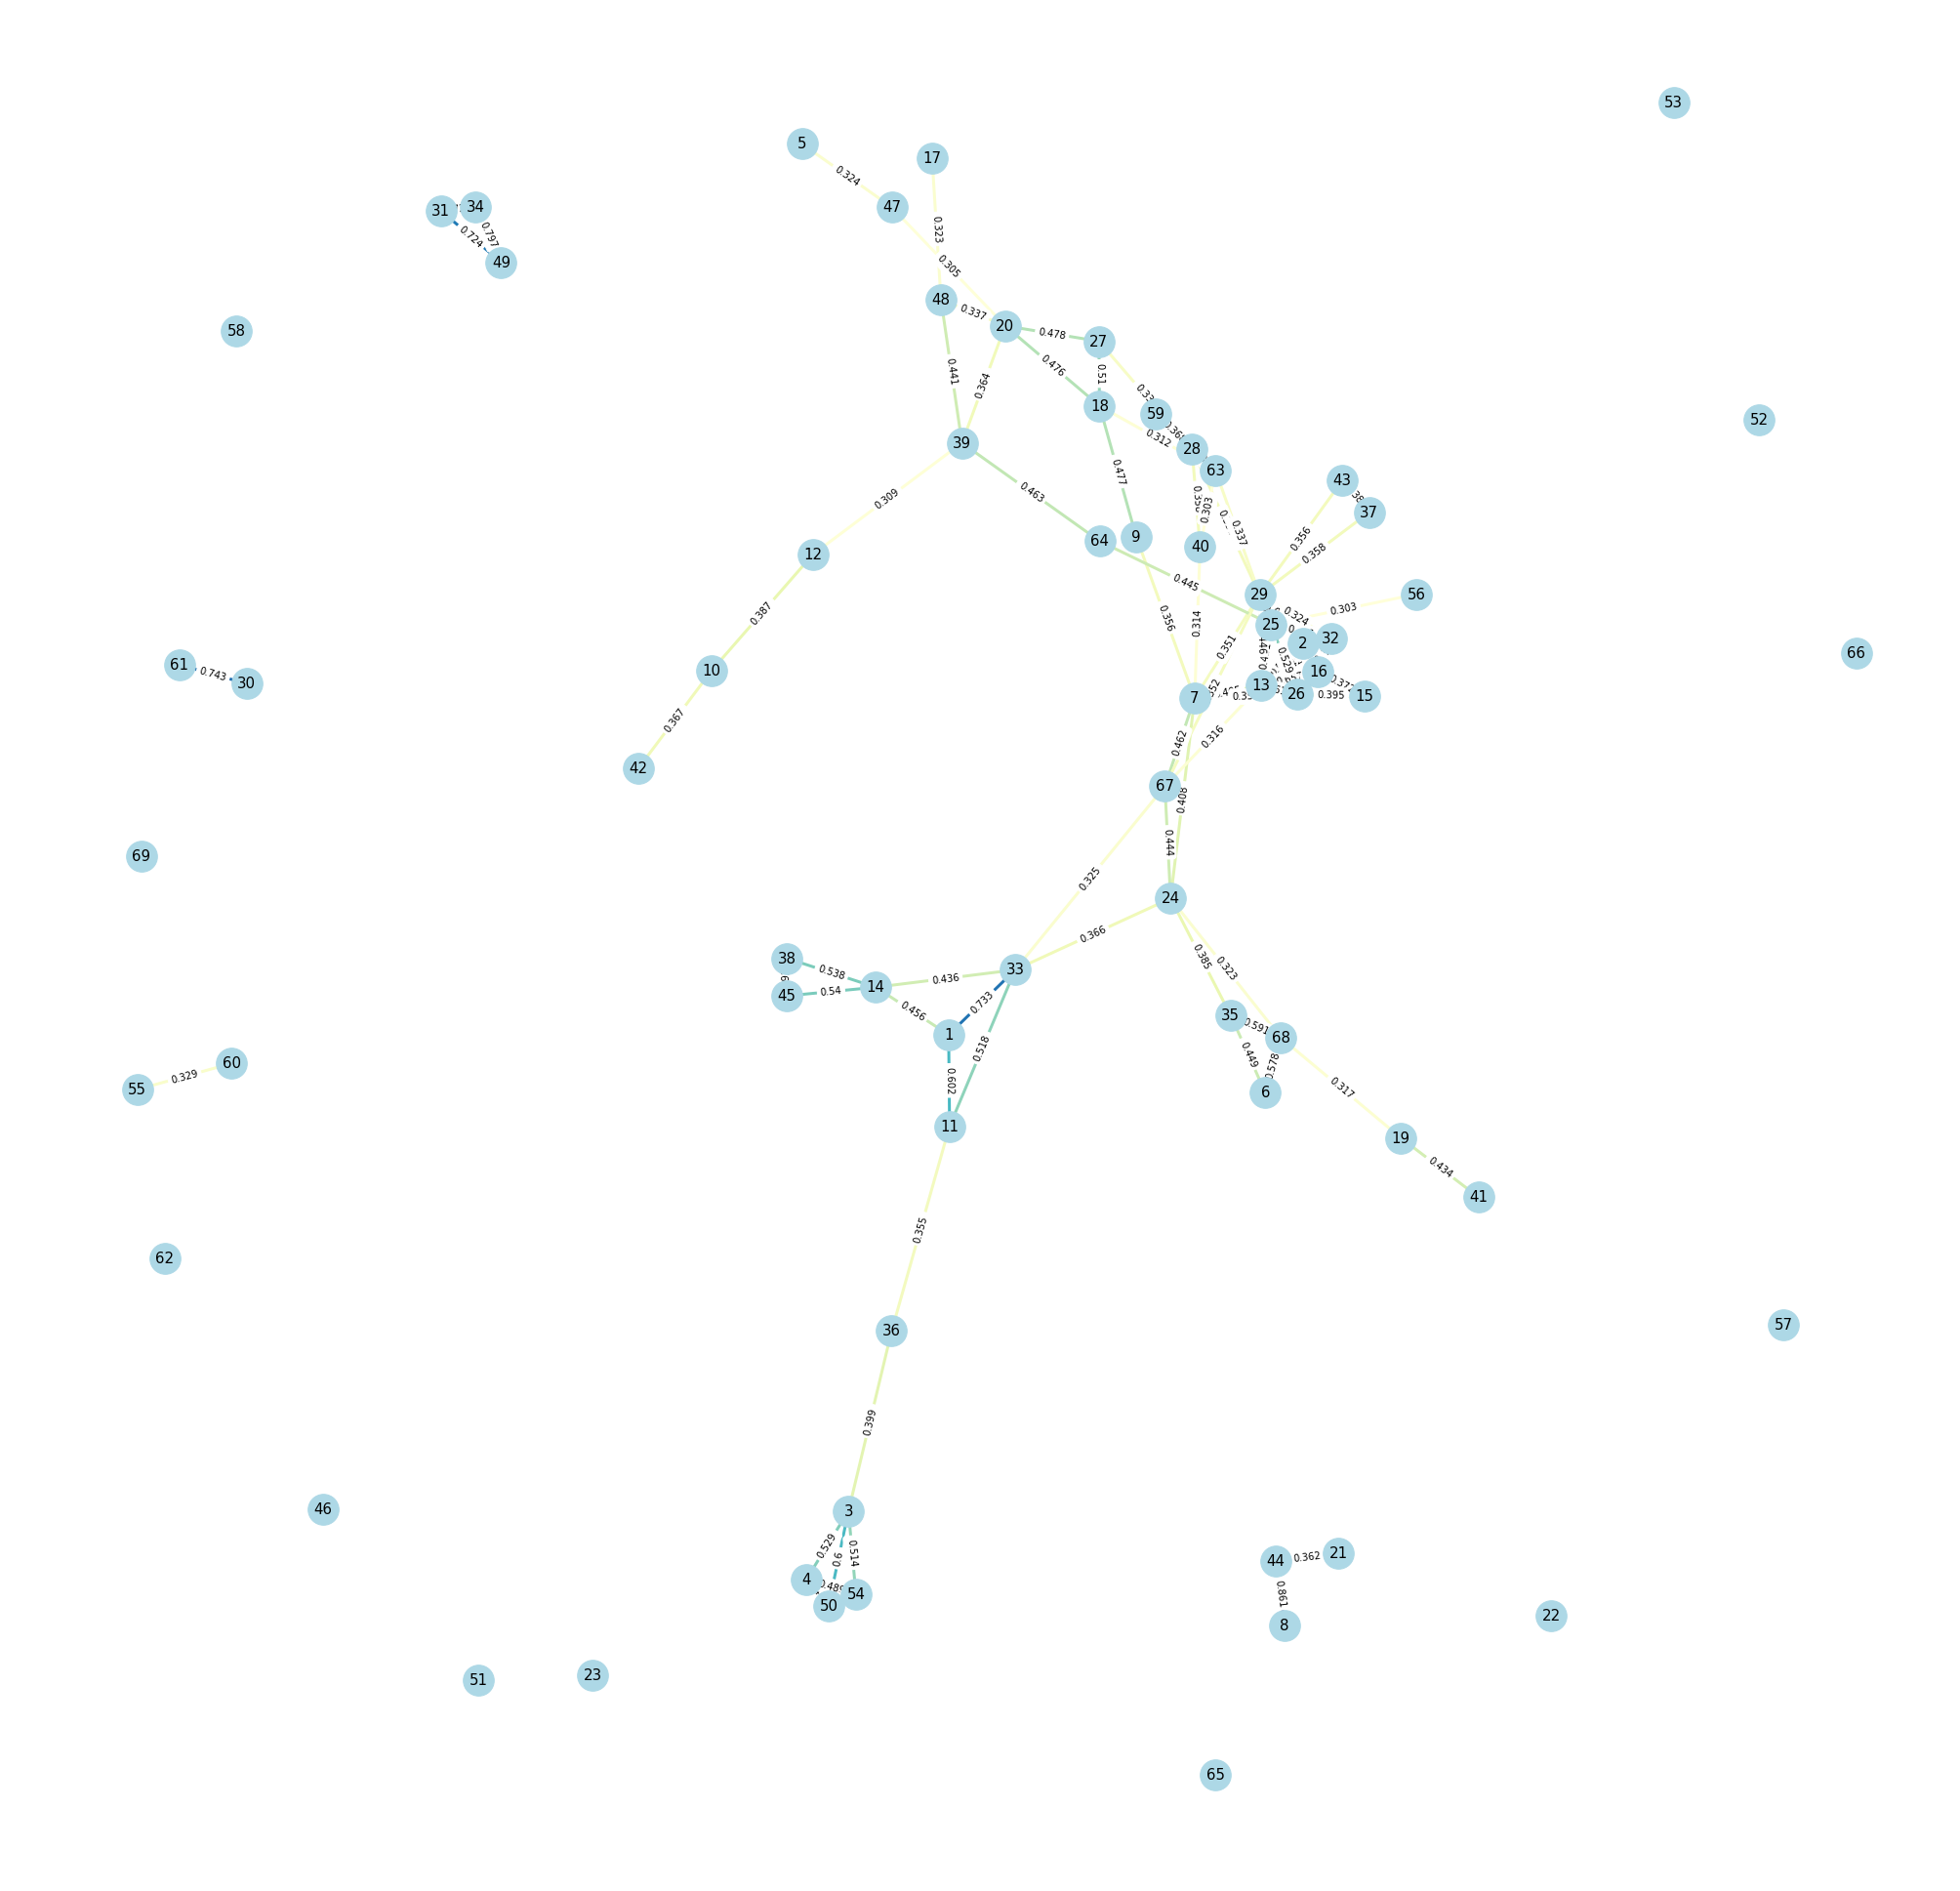

In [9]:
total_graph = create_graph(cell_transients_dataframe)
plot_graph(total_graph)

## The degree of a node is the number of edges that link it to the rest of the network. According to Bullmore et al. 2009, node degree is the most fundamental network measure, and most other measures are ultimately linked to node degree. 
### So, we output a dictionary that contains each node (neuron) in the network and its corresponding degree
- For the sake of curiosity, we retrieve the name of the node that has the greatest degree in this particular network
    - As we can see, in the case of the dataset for drd87, the degree of node (neuron) $29$ is $11$, and this is the largest degree of any node for this particular network

In [10]:
max(dict(total_graph.degree()), key=dict(total_graph.degree()).get)

29

## A simple bar plot that depicts the degree of each node (neuron) in the network

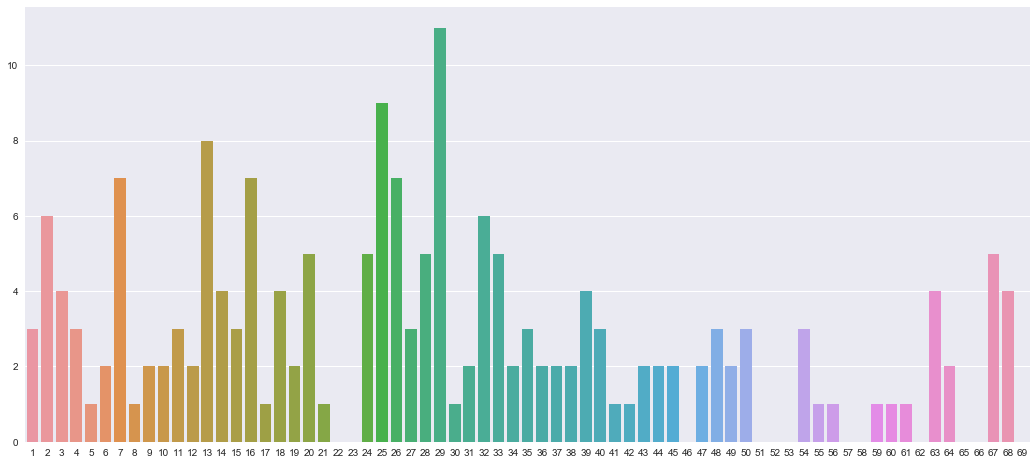

In [11]:
sns.set(rc={"figure.figsize": (18, 8)})
sns.barplot(x=list(dict(total_graph.degree()).keys()), y=list(dict(total_graph.degree()).values()));

## In complex networks, the degree distributions are non-Gaussian, and often have a long tail towards high degrees (Bullmore et al. 2009)
### We plot the distribution of the degrees of all the nodes (neurons) in our network to see if this is the case with the network of neurons imaged for the given mouse.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



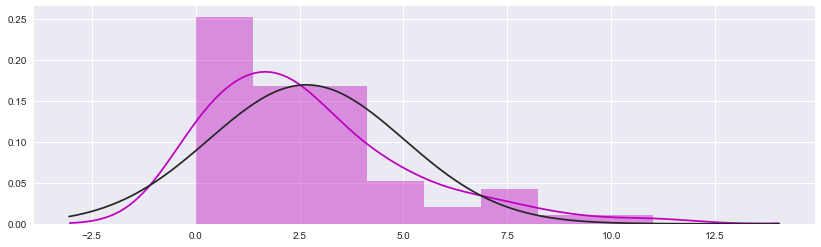

In [12]:
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(total_graph.degree()).values()), color='m', fit=stats.norm);

## Using the [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) algorithm, we find that node (neuron) 33 has the highest centrality in this network
### Hubs are nodes with high degree, or high centrality. The centrality of a node measures how many of the shortest paths between all other node pairs in the network pass through it. A node with high centrality is thus crucial to efficient communication (Bullmore et al. 2009)
### Going off of this, we can assume that neuron 33 is a hub in this partricular network.

In [13]:
compute_network_measures(total_graph)

{'assortativity': 0.41795175958877034,
 'clustering coefficient': {1: 0.6666666666666666,
  2: 0.9333333333333333,
  3: 0.5,
  4: 1.0,
  5: 0,
  6: 1.0,
  7: 0.23809523809523808,
  8: 0,
  9: 0,
  10: 0,
  11: 0.3333333333333333,
  12: 0,
  13: 0.6428571428571429,
  14: 0.3333333333333333,
  15: 1.0,
  16: 0.7619047619047619,
  17: 0,
  18: 0.16666666666666666,
  19: 0,
  20: 0.2,
  21: 0,
  22: 0,
  23: 0,
  24: 0.3,
  25: 0.4444444444444444,
  26: 0.6190476190476191,
  27: 0.3333333333333333,
  28: 0.2,
  29: 0.2727272727272727,
  30: 0,
  31: 1.0,
  32: 0.9333333333333333,
  33: 0.3,
  34: 1.0,
  35: 0.6666666666666666,
  36: 0,
  37: 1.0,
  38: 1.0,
  39: 0.16666666666666666,
  40: 0.3333333333333333,
  41: 0,
  42: 0,
  43: 1.0,
  44: 0,
  45: 1.0,
  46: 0,
  47: 0,
  48: 0.3333333333333333,
  49: 1.0,
  50: 1.0,
  51: 0,
  52: 0,
  53: 0,
  54: 1.0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0.3333333333333333,
  64: 0,
  65: 0,
  66: 0,
  67: 0

In [14]:
nx.betweenness_centrality(total_graph)

{1: 0.003950834064969272,
 2: 0.0004624984322087044,
 3: 0.05662862159789289,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.09722344161545213,
 8: 0.0,
 9: 0.03779997073456249,
 10: 0.019754170324846356,
 11: 0.08999122036874452,
 12: 0.038630377524143986,
 13: 0.04522293992223754,
 14: 0.038630377524143986,
 15: 0.0,
 16: 0.004110226180024248,
 17: 0.0,
 18: 0.05235220954053262,
 19: 0.019754170324846356,
 20: 0.07511706175007316,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.10637463940800203,
 25: 0.098549793051549,
 26: 0.014353651908524608,
 27: 0.020880889669300552,
 28: 0.04600892595844308,
 29: 0.1451189430996279,
 30: 0.0,
 31: 0.0,
 32: 0.0004624984322087044,
 33: 0.16198419666374012,
 34: 0.0,
 35: 0.009218612818261633,
 36: 0.07374890254609306,
 37: 0.0,
 38: 0.0,
 39: 0.07753877670471175,
 40: 0.00455965968476943,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0004389815627743635,
 45: 0.0,
 46: 0.0,
 47: 0.019754170324846356,
 48: 0.019754170324846356,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 

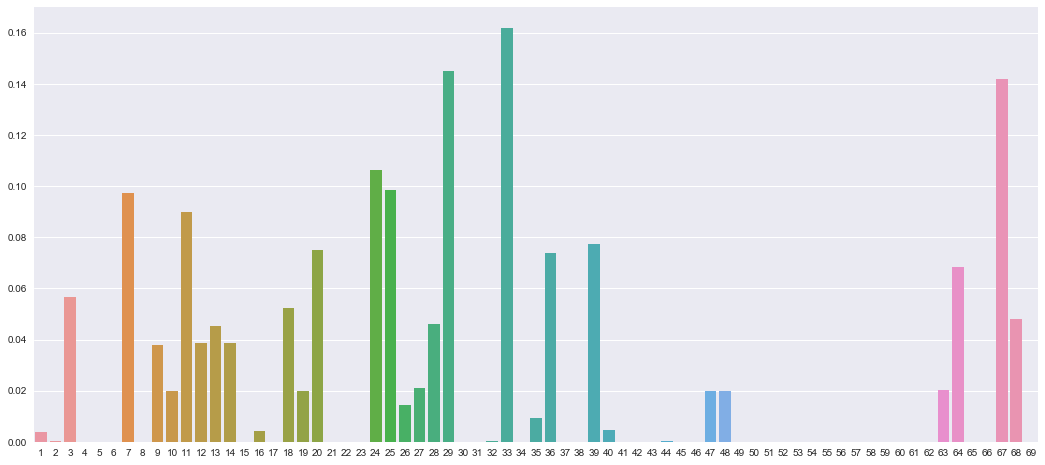

In [15]:
sns.set(rc={"figure.figsize": (18, 8)})
sns.barplot(x=list(nx.betweenness_centrality(total_graph).keys()), y=list(nx.betweenness_centrality(total_graph).values()));

## In accordance with Bullmore et al. 2009, our network measures must be compared with the (null) distribution of equivalent parameters estimated in random networks containing the same number of nodes and connections. 
> "Statistical testing of network parameters may best be conducted by permutation- or resampling-based methods of non-parametric inference given the lack of statistical theory concerning the distribution of most network metrics." (Bullmore et al. 2009)

## We by plotting an undirected graph of the same number of nodes (neurons) from our dataset and we draw the same number of edges (the amount of correlated neurons in our dataset) between them randomly selected pairs of nodes.

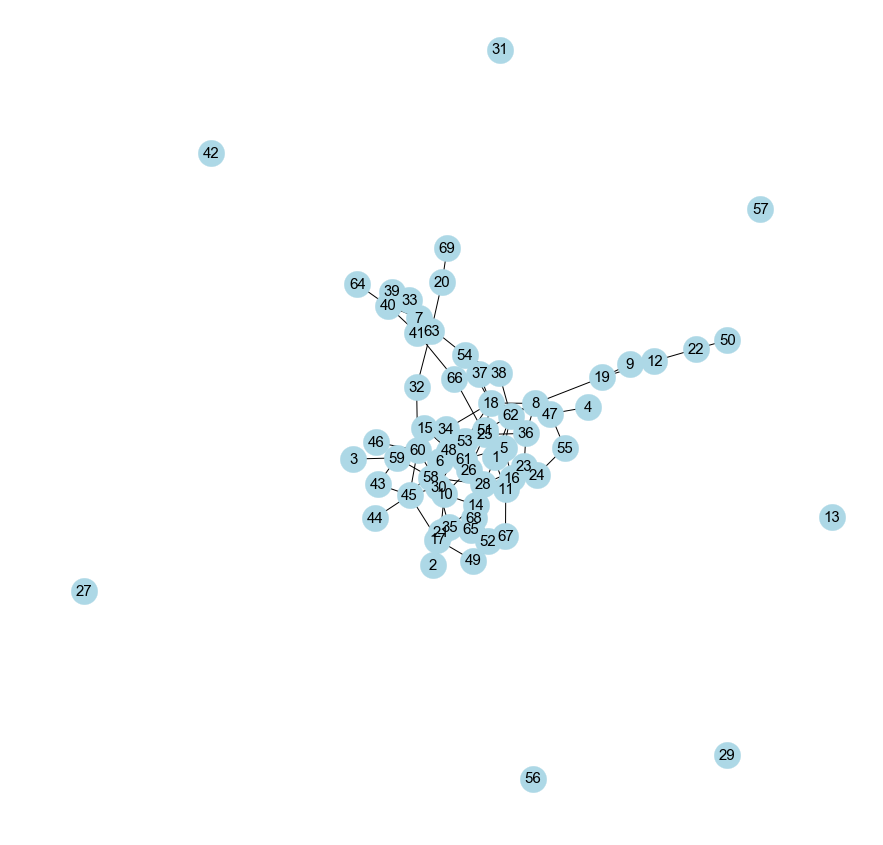

In [17]:
random_graph = create_random_graph(cell_transients_dataframe)
plot_random_graph(random_graph)

## In random networks all connections are equally probably, resulting in a Gaussian and symmetrically centered degree distribution (Bullmore et al. 2009). So, we quickly plot the degree distribution, for the above random network, to see if it is Gaussian 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



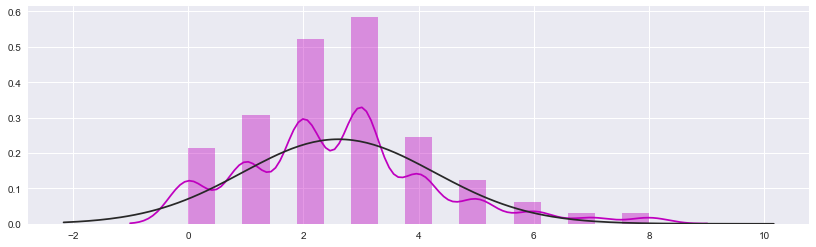

In [18]:
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(random_graph.degree()).values()), color='m', fit=stats.norm);

## We compute the network measures of this random network to see whether the centrality measure of the complex network we graphed before is actually significant.

In [19]:
compute_network_measures(random_graph)

{'assortativity': -0.082323515459916272,
 'clustering coefficient': {1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0.3333333333333333,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 1.0,
  16: 0,
  17: 0,
  18: 0.047619047619047616,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0.3333333333333333,
  24: 0.3333333333333333,
  25: 0.06666666666666667,
  26: 0,
  27: 0,
  28: 0.03571428571428571,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0.2,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 1.0,
  40: 0.16666666666666666,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 0.3333333333333333,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 0,
  67: 0,
  68: 0,
  69: 0},
 'max clique size': 3,
 'mean betweenness centrality': 0.038935756002595717}

In [20]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

activity_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/activity_drd87.csv', header=None)
behavior_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/behavior_drd87.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = ['neuron' + str(i) for i in range(1, len(activity_df.columns) + 1)]

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
# TODO: Utilize a pandas Series instead of a list comprehension in the line below
behavior_df['Running_frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
result_dataframe = pd.concat([cell_transients_dataframe, behavior_df], axis=1)

## We plot the network of neurons for all of the time that the given mouse was in the closed arms.

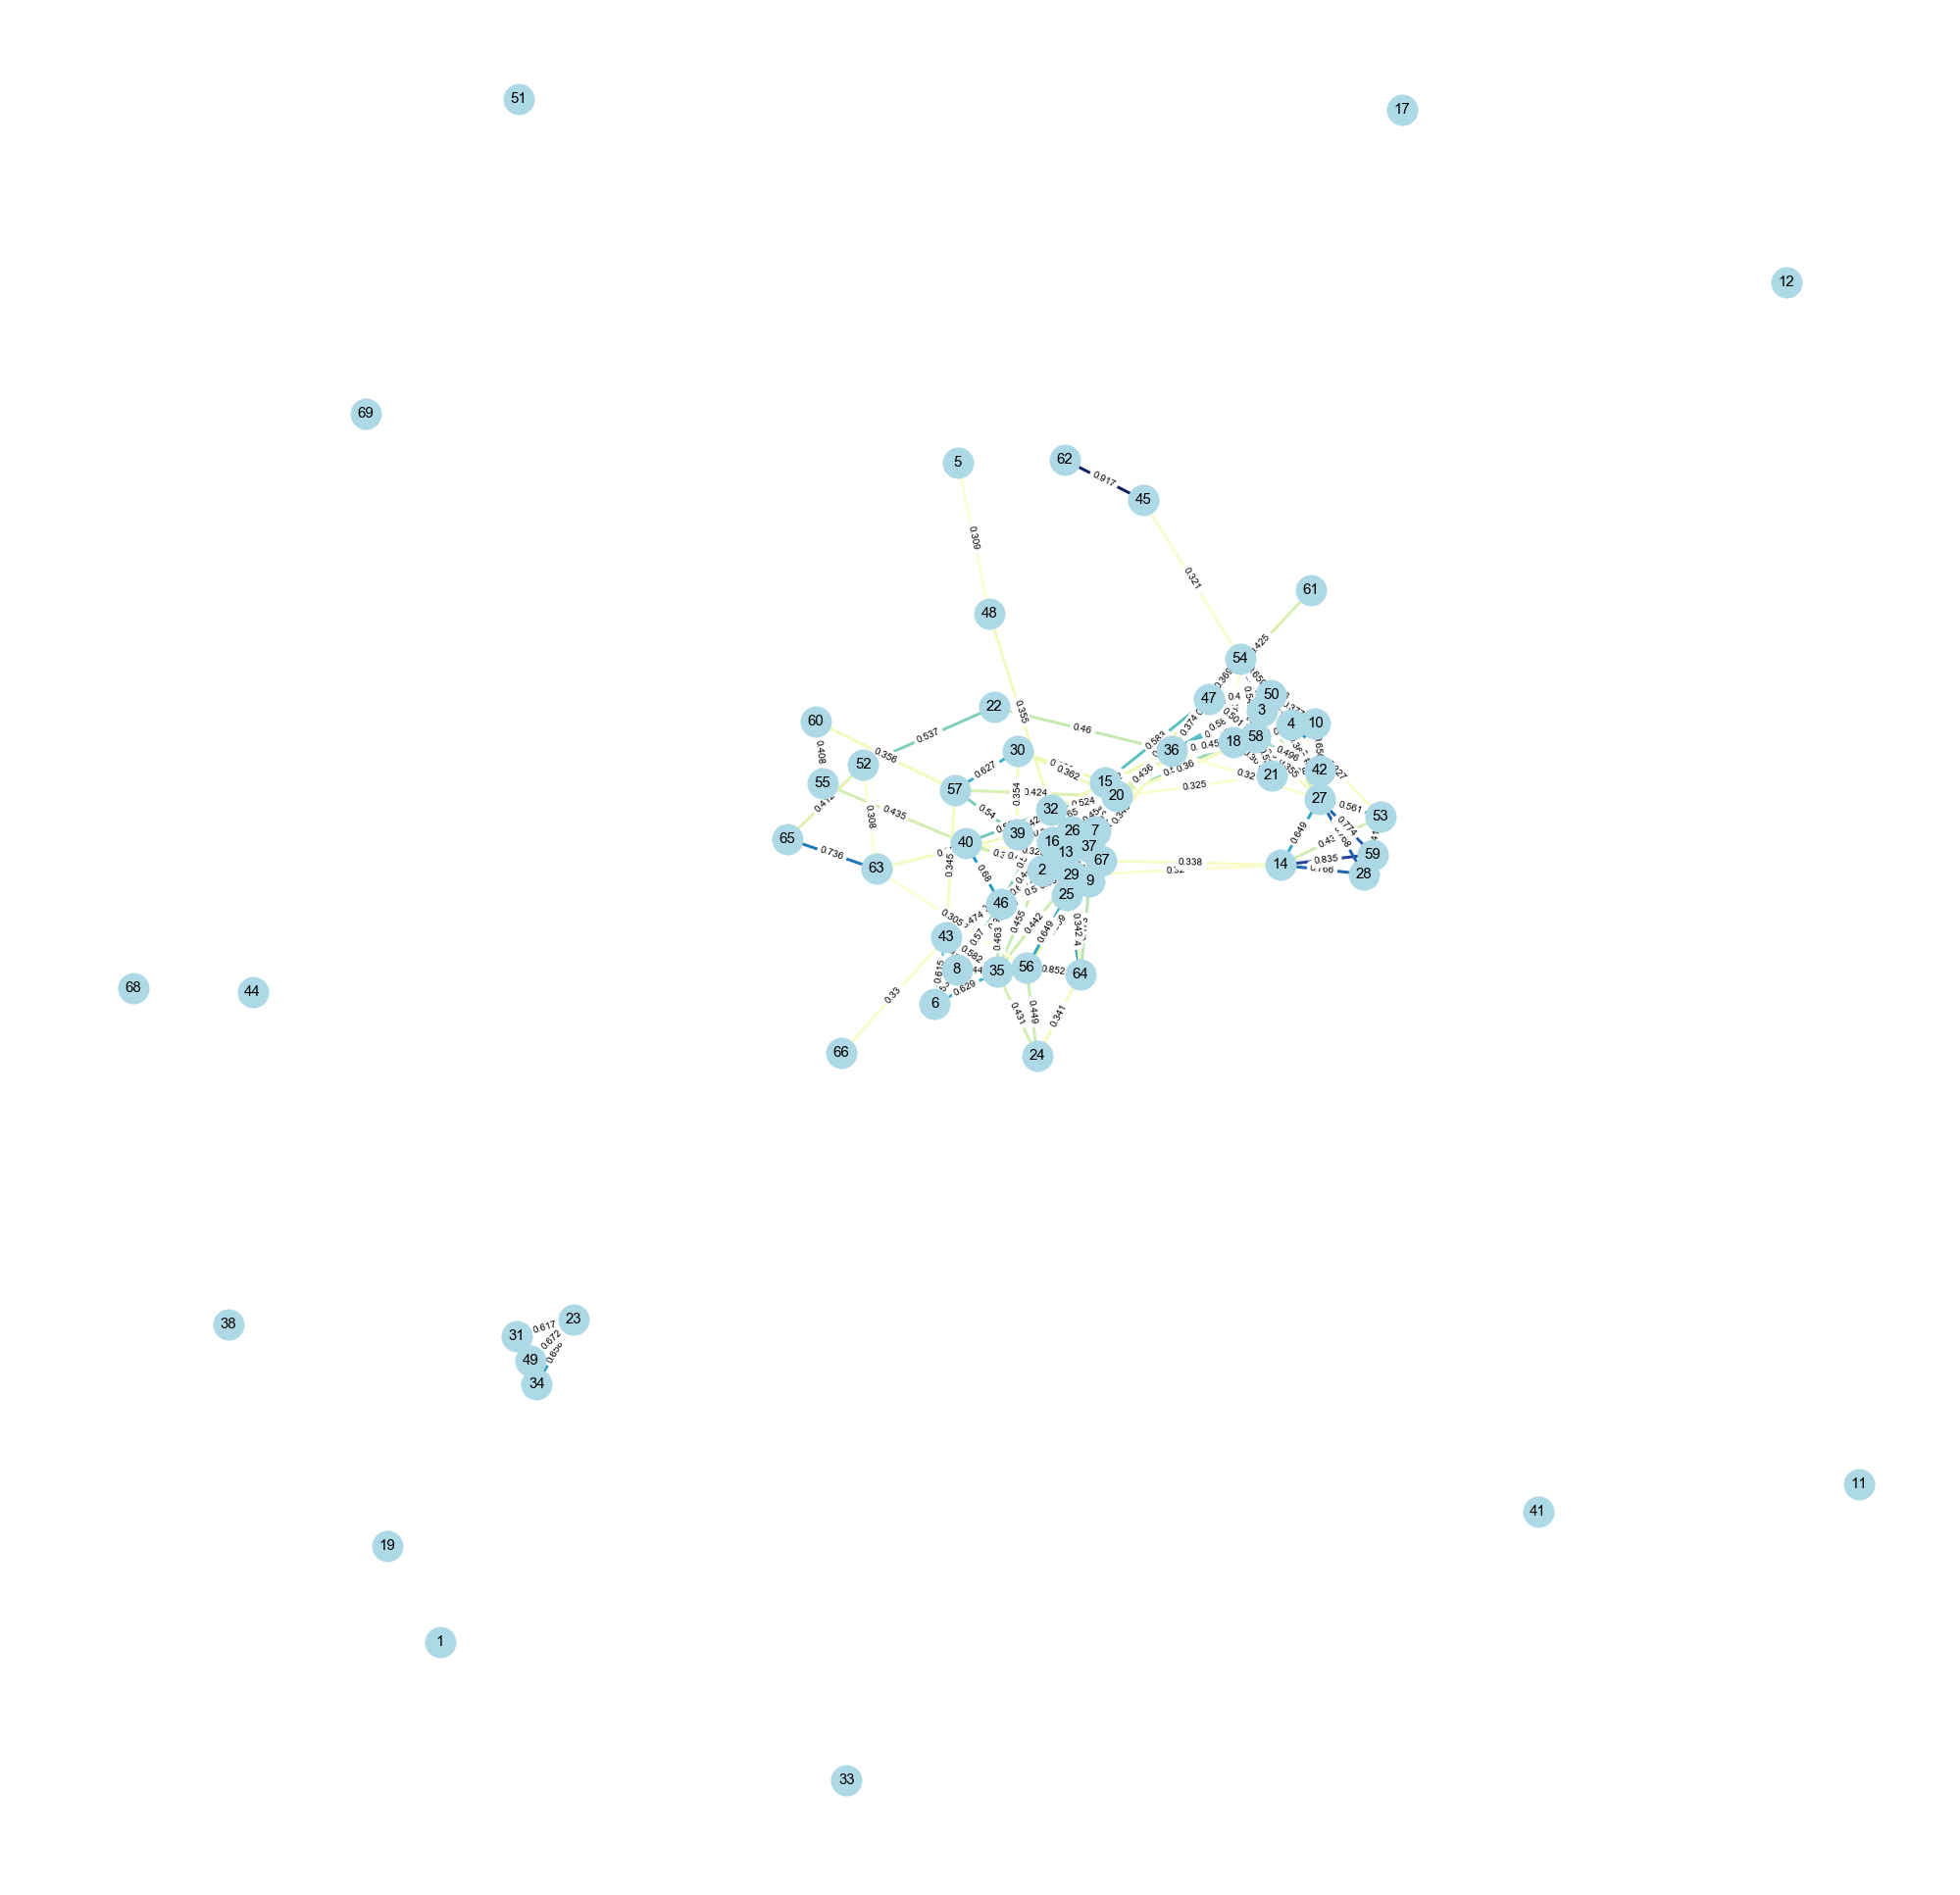

In [33]:
# Using the result_dataframe, we get the indices for when the mouse was in ClosedArms_centerpoint
indices = result_dataframe.loc[result_dataframe["OpenArms_centerpoint"] != 0].index

open_arms_graph = create_graph(cell_transients_dataframe.iloc[indices])
plot_graph(open_arms_graph)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



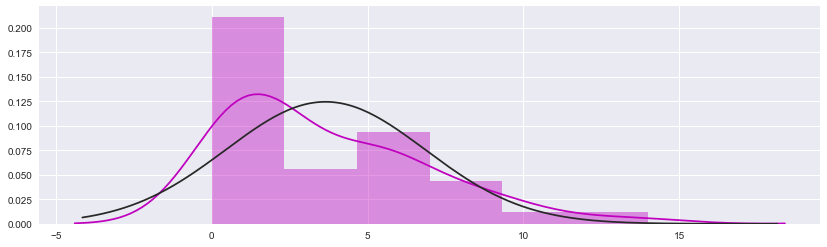

In [25]:
sns.set(rc={"figure.figsize": (14, 4)})
sns.distplot(list(dict(open_arms_graph.degree()).values()), color='m', fit=stats.norm);

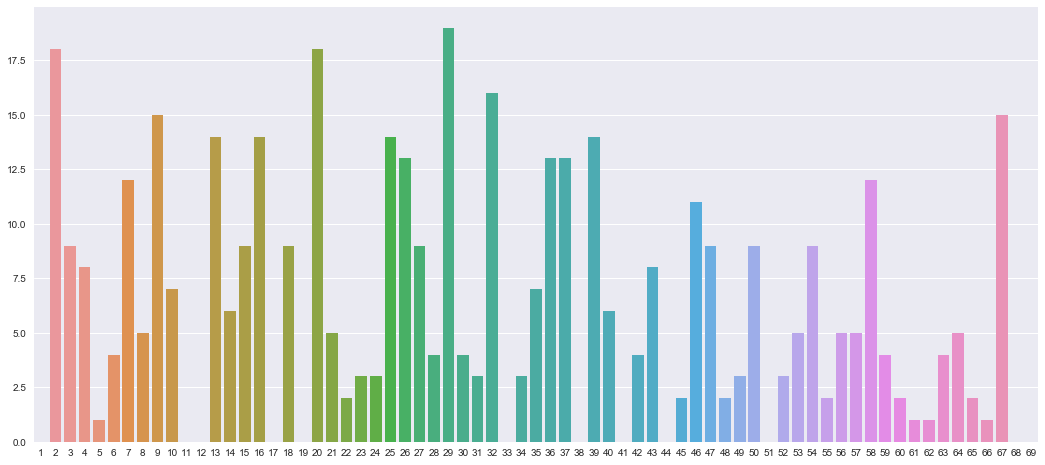

In [40]:
sns.set(rc={"figure.figsize": (18, 8)})
sns.barplot(x=list(dict(open_arms_graph.degree()).keys()), y=list(dict(open_arms_graph.degree()).values()));

In [26]:
compute_network_measures(open_arms_graph)

{'assortativity': 0.39790168704361678,
 'clustering coefficient': {1: 0.6,
  2: 0.3,
  3: 0,
  4: 1.0,
  5: 0.6666666666666666,
  6: 1.0,
  7: 0.34065934065934067,
  8: 0,
  9: 0.39285714285714285,
  10: 0.4722222222222222,
  11: 0.5333333333333333,
  12: 0.26666666666666666,
  13: 0.6,
  14: 0.3333333333333333,
  15: 0.4642857142857143,
  16: 0,
  17: 0.3333333333333333,
  18: 0.4666666666666667,
  19: 0.4,
  20: 0.5333333333333333,
  21: 0,
  22: 0,
  23: 0.6666666666666666,
  24: 0.4393939393939394,
  25: 0,
  26: 0,
  27: 0.3333333333333333,
  28: 0.4444444444444444,
  29: 0.35714285714285715,
  30: 1.0,
  31: 0,
  32: 0,
  33: 0.4222222222222222,
  34: 0.38095238095238093,
  35: 0.5,
  36: 1.0,
  37: 1.0,
  38: 0.6666666666666666,
  39: 0.16666666666666666,
  40: 0.8,
  41: 1.0,
  42: 0,
  43: 1.0,
  44: 0,
  45: 0.6666666666666666,
  46: 0,
  47: 0,
  48: 0.6,
  49: 0.3333333333333333,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0.4,
  56: 1.0,
  57: 0,
  58: 0,
  59: 0,
 